In [52]:
import pandas as pd

# Load Data
train = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")
trainTarget = train.loc[:, "satisfaction"]
testTarget = test.loc[:, "satisfaction"]

In [2]:
import seaborn as sn
import matplotlib.pyplot as plt

# Make dummy features
trainDummy = pd.get_dummies(train[["Gender", "Customer Type", "Type of Travel", "Class"]])
trainDummy = train.merge(trainDummy, left_index=True, right_index=True)

testDummy = pd.get_dummies(test[["Gender", "Customer Type", "Type of Travel", "Class"]])
testDummy = test.merge(testDummy, left_index=True, right_index=True)

# corrHeat of all variables
corrMatrix = trainDummy.corr()
sn.set(rc = {"figure.figsize":(20, 20)})
sn.heatmap(corrMatrix, annot=True)
# plt.show()

<AxesSubplot:>

In [3]:
# Select important variables
trainFil = train.loc[:, ["Flight Distance", "Cleanliness"]]
trainFil = trainFil.merge(train.loc[:, "Online boarding":"Baggage handling"], left_index=True, right_index=True)
trainFil = trainFil.merge(trainDummy.loc[:, "Type of Travel_Business travel":"Class_Eco"], left_index=True, right_index=True)

testFil = test.loc[:, ["Flight Distance", "Cleanliness"]]
testFil = testFil.merge(test.loc[:, "Online boarding":"Baggage handling"], left_index=True, right_index=True)
testFil = testFil.merge(testDummy.loc[:, "Type of Travel_Business travel":"Class_Eco"], left_index=True, right_index=True)

In [4]:
from sklearn import preprocessing as pre

# Binarize flight distance on threshold = 2400
dist = trainFil.loc[:, "Flight Distance"]
binarizer = pre.Binarizer(threshold=2400)
distBi = binarizer.transform([dist]).T
trainFil.loc[:, "Flight Distance"] = distBi

dist = testFil.loc[:, "Flight Distance"]
binarizer = pre.Binarizer(threshold=2400)
distBi = binarizer.transform([dist]).T
testFil.loc[:, "Flight Distance"] = distBi

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

kNeighbor = []
accTrend = []
for n in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=n).fit(trainFil, trainTarget)
    pred = knn.predict(testFil)
    eva = classification_report(y_true=testTarget, y_pred=pred, output_dict=True)
    kNeighbor.append(n)
    accTrend.append(eva["accuracy"])

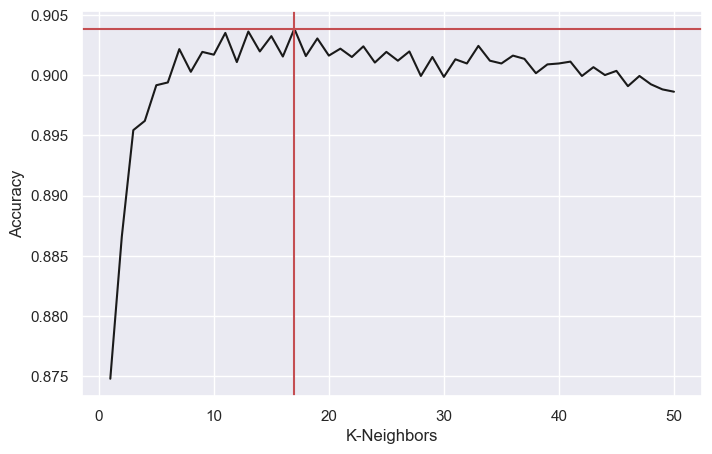

In [51]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.plot(kNeighbor, accTrend, color="k")
plt.axvline(x = accTrend.index(max(accTrend)) + 1, color = "r")
plt.axhline(y = max(accTrend), color = "r")
plt.xlabel("K-Neighbors")
plt.ylabel("Accuracy")

plt.show()
